# **Notebook 03: 1D CNN Model Development, Training, and Evaluation**
--- 
**Objective:** In this notebook, we will take the preprocessed, segmented, and normalized data from the previous step and use it to build, train, and evaluate a 1D Convolutional Neural Network (CNN) for bearing fault diagnosis.

**Key Steps:**
1.  Load the processed datasets (`.npy` files) and the fitted `StandardScaler`.
2.  Perform label encoding on the fault type labels.
3.  Convert all data from NumPy arrays to PyTorch Tensors in the correct shape for a 1D CNN.
4.  Define the 1D CNN model architecture using `torch.nn.Module`.
5.  Create PyTorch `Dataset` and `DataLoader` objects to handle batching and shuffling.
6.  Run two experiments:
    * Training the model on the original, imbalanced data.
    * Training the model on the SMOTE-balanced data.
7.  Evaluate the performance of both models on the unseen test set.
8.  Conduct a robustness test by injecting noise into the test signals to understand the model's limits.

### 1. Setup and Imports

In [1]:
import torch

# Check if CUDA (GPU support) is available and set the device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA is available! PyTorch will use the GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Number of GPUs available: {torch.cuda.device_count()}")
else:
    device = torch.device("cpu")
    print("CUDA is NOT available. PyTorch will use the CPU.")

CUDA is available! PyTorch will use the GPU: NVIDIA GeForce RTX 2060
  Number of GPUs available: 1


In [2]:
import os
import numpy as np
import pandas as pd
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns

# For reproducibility
SEED = 25
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Define paths
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
PROCESSED_DATA_DIR = os.path.join(project_root, 'data', 'processed')

print(f"Project Root (estimated): {project_root}")
print(f"Processed Data Directory: {PROCESSED_DATA_DIR}")

Project Root (estimated): D:\Coding\GitHub\AI-Bearing-Diagnosis
Processed Data Directory: D:\Coding\GitHub\AI-Bearing-Diagnosis\data\processed


### 2. Load Processed Data

In [3]:
print("--- Loading Processed Datasets ---")

try:
    X_train_scaled = np.load(os.path.join(PROCESSED_DATA_DIR, 'X_train_scaled.npy'))
    y_train = np.load(os.path.join(PROCESSED_DATA_DIR, 'y_train.npy'), allow_pickle=True)
    
    X_train_balanced_scaled = np.load(os.path.join(PROCESSED_DATA_DIR, 'X_train_balanced_scaled.npy'))
    y_train_balanced = np.load(os.path.join(PROCESSED_DATA_DIR, 'y_train_balanced.npy'), allow_pickle=True)
    
    X_val_scaled = np.load(os.path.join(PROCESSED_DATA_DIR, 'X_val_scaled.npy'))
    y_val = np.load(os.path.join(PROCESSED_DATA_DIR, 'y_val.npy'), allow_pickle=True)
    
    X_test_scaled = np.load(os.path.join(PROCESSED_DATA_DIR, 'X_test_scaled.npy'))
    y_test = np.load(os.path.join(PROCESSED_DATA_DIR, 'y_test.npy'), allow_pickle=True)
    
    scaler = joblib.load(os.path.join(PROCESSED_DATA_DIR, 'standard_scaler.joblib'))
    
    print("Successfully loaded all .npy datasets and the scaler.")
    print(f"  Shape of X_train_scaled: {X_train_scaled.shape}, y_train: {y_train.shape}")
    print(f"  Shape of X_train_balanced_scaled: {X_train_balanced_scaled.shape}, y_train_balanced: {y_train_balanced.shape}")
    print(f"  Shape of X_val_scaled: {X_val_scaled.shape}, y_val: {y_val.shape}")
    print(f"  Shape of X_test_scaled: {X_test_scaled.shape}, y_test: {y_test.shape}")
    print(f"  Scaler loaded: {scaler}")

except FileNotFoundError as e:
    print(f"Error: One or more data files not found. Please run Notebook 02 first.")

--- Loading Processed Datasets ---
Successfully loaded all .npy datasets and the scaler.
  Shape of X_train_scaled: (1131, 2048), y_train: (1131,)
  Shape of X_train_balanced_scaled: (2264, 2048), y_train_balanced: (2264,)
  Shape of X_val_scaled: (283, 2048), y_val: (283,)
  Shape of X_test_scaled: (824, 2048), y_test: (824,)
  Scaler loaded: StandardScaler()


### 3. Data Preparation for PyTorch

In [4]:
print("\n--- Performing Label Encoding ---")
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train_encoded = label_encoder.transform(y_train)
y_train_balanced_encoded = label_encoder.transform(y_train_balanced)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print("Label encoding mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"  Class '{class_name}': Encoded to {i}")

num_classes = len(label_encoder.classes_)
print(f"\nNumber of unique classes: {num_classes}")


--- Performing Label Encoding ---
Label encoding mapping:
  Class 'BF': Encoded to 0
  Class 'IRF': Encoded to 1
  Class 'Normal': Encoded to 2
  Class 'ORF': Encoded to 3

Number of unique classes: 4


In [5]:
print("\n--- Converting Data to PyTorch Tensors ---")

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)
X_train_balanced_tensor = torch.tensor(X_train_balanced_scaled, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)

y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_train_balanced_tensor = torch.tensor(y_train_balanced_encoded, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

print("Data successfully converted to PyTorch tensors.")
print(f"Shape of X_train_balanced_tensor: {X_train_balanced_tensor.shape}")


--- Converting Data to PyTorch Tensors ---
Data successfully converted to PyTorch tensors.
Shape of X_train_balanced_tensor: torch.Size([2264, 1, 2048])


### 4. Define 1D CNN Model Architecture

In [6]:
class Cnn1D(nn.Module):
    def __init__(self, num_classes=4):
        super(Cnn1D, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=32, stride=4, padding=14),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=16, stride=2, padding=7),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=8, stride=1, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=448, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=128, out_features=num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

print("Cnn1D class defined.")

Cnn1D class defined.


### 5. Create Datasets and DataLoaders

In [7]:
class BearingDataset(Dataset):
    """Custom PyTorch Dataset for bearing vibration data."""
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

BATCH_SIZE = 64

# Datasets
train_imbalanced_dataset = BearingDataset(X_train_tensor, y_train_tensor)
train_balanced_dataset = BearingDataset(X_train_balanced_tensor, y_train_balanced_tensor)
val_dataset = BearingDataset(X_val_tensor, y_val_tensor)
test_dataset = BearingDataset(X_test_tensor, y_test_tensor)

# DataLoaders
train_imbalanced_loader = DataLoader(dataset=train_imbalanced_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_balanced_loader = DataLoader(dataset=train_balanced_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Datasets and DataLoaders created.")

Datasets and DataLoaders created.


### 6. Training and Validation Loop

In [8]:
def run_experiment(experiment_name, train_loader, val_loader, num_epochs=25):
    print(f"\n--- Starting Experiment: {experiment_name} ---")
    
    model = Cnn1D(num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    best_val_loss = float('inf')
    best_model_state = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_train_loss, correct_train_preds, total_train_samples = 0.0, 0, 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * features.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train_samples += labels.size(0)
            correct_train_preds += (predicted == labels).sum().item()
            
        epoch_train_loss = running_train_loss / total_train_samples
        epoch_train_acc = correct_train_preds / total_train_samples
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        
        # Validation
        model.eval()
        running_val_loss, correct_val_preds, total_val_samples = 0.0, 0, 0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                running_val_loss += loss.item() * features.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val_samples += labels.size(0)
                correct_val_preds += (predicted == labels).sum().item()
        
        epoch_val_loss = running_val_loss / total_val_samples
        epoch_val_acc = correct_val_preds / total_val_samples
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()

    print(f"Experiment finished.")
    
    model.load_state_dict(best_model_state)
    return model, history

print("Reusable `run_experiment` function defined.")

Reusable `run_experiment` function defined.


### 7. Run Experiments

In [9]:
# Experiment 1: Train on the original, imbalanced data
imbalanced_model, imbalanced_history = run_experiment(
    experiment_name="Imbalanced_Data",
    train_loader=train_imbalanced_loader,
    val_loader=val_loader,
    num_epochs=25
)

# Experiment 2: Train on the SMOTE-balanced data
balanced_model, balanced_history = run_experiment(
    experiment_name="Balanced_Data_(SMOTE)",
    train_loader=train_balanced_loader,
    val_loader=val_loader,
    num_epochs=25
)


--- Starting Experiment: Imbalanced_Data ---
Epoch 1/25 | Train Loss: 0.5992, Train Acc: 0.7825 | Val Loss: 0.2494, Val Acc: 0.8375
Epoch 2/25 | Train Loss: 0.0491, Train Acc: 0.9982 | Val Loss: 0.0013, Val Acc: 1.0000
Epoch 3/25 | Train Loss: 0.0033, Train Acc: 1.0000 | Val Loss: 0.0002, Val Acc: 1.0000
Epoch 4/25 | Train Loss: 0.0014, Train Acc: 1.0000 | Val Loss: 0.0001, Val Acc: 1.0000
Epoch 5/25 | Train Loss: 0.0010, Train Acc: 1.0000 | Val Loss: 0.0001, Val Acc: 1.0000
Epoch 6/25 | Train Loss: 0.0008, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch 7/25 | Train Loss: 0.0007, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch 8/25 | Train Loss: 0.0005, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch 9/25 | Train Loss: 0.0006, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch 10/25 | Train Loss: 0.0006, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch 11/25 | Train Loss: 0.0004, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.

### 8. Analyze and Evaluate Results

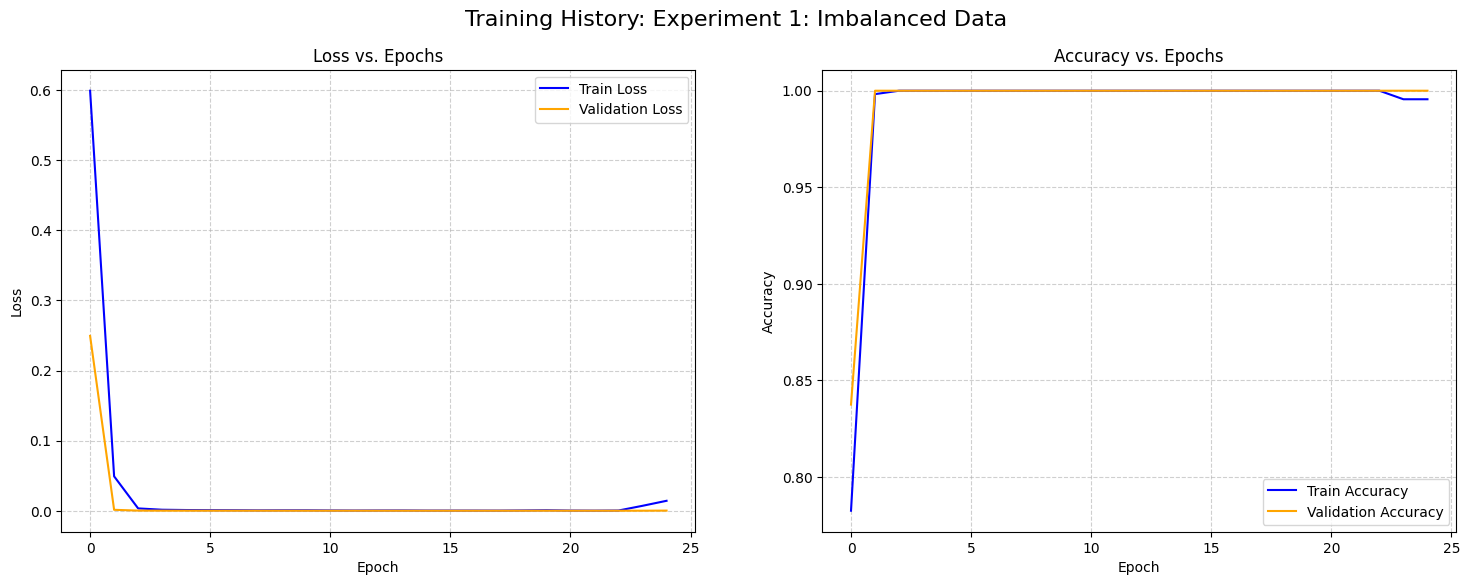

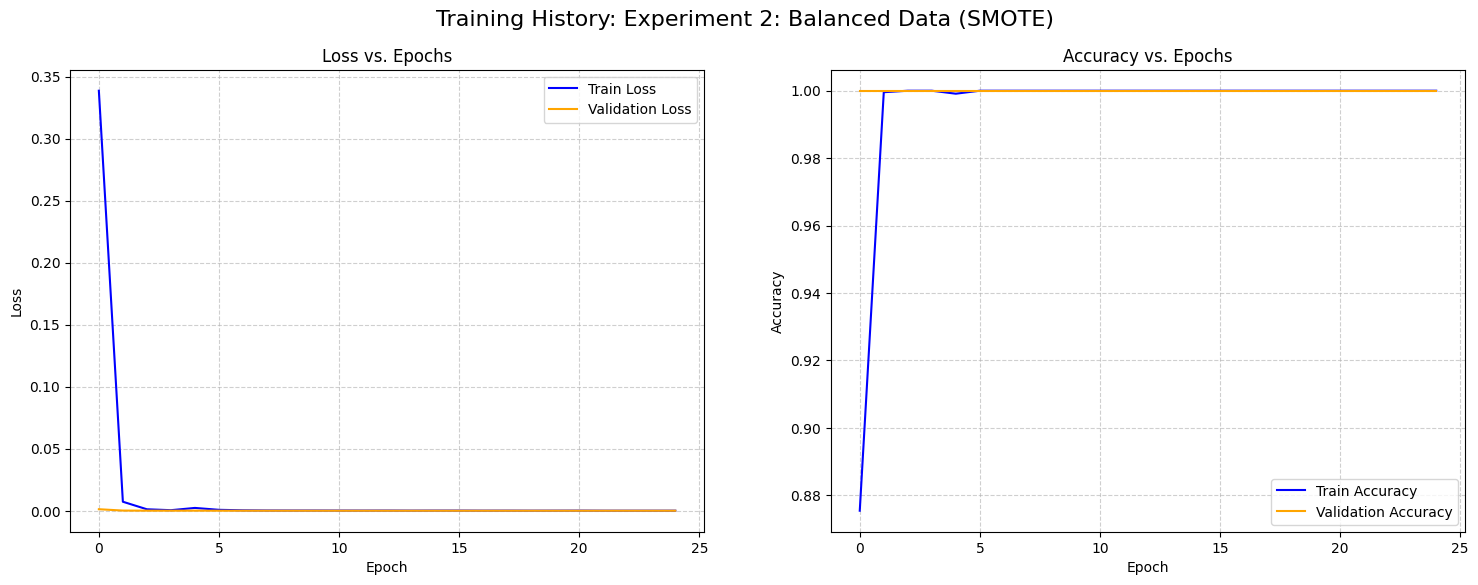

In [10]:
def plot_history(history, experiment_name):
    """Plots the training and validation loss and accuracy curves."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'Training History: {experiment_name}', fontsize=16)

    ax1.plot(history['train_loss'], label='Train Loss', color='blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='orange')
    ax1.set_title('Loss vs. Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    ax2.plot(history['train_acc'], label='Train Accuracy', color='blue')
    ax2.plot(history['val_acc'], label='Validation Accuracy', color='orange')
    ax2.set_title('Accuracy vs. Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.show()

plot_history(imbalanced_history, "Experiment 1: Imbalanced Data")
plot_history(balanced_history, "Experiment 2: Balanced Data (SMOTE)")


--- Evaluating Model for Experiment: Imbalanced Data ---

Classification Report:
              precision    recall  f1-score   support

          BF     1.0000    1.0000    1.0000       117
         IRF     1.0000    1.0000    1.0000       118
      Normal     1.0000    1.0000    1.0000       472
         ORF     1.0000    1.0000    1.0000       117

    accuracy                         1.0000       824
   macro avg     1.0000    1.0000    1.0000       824
weighted avg     1.0000    1.0000    1.0000       824

Overall Test Accuracy: 1.0000


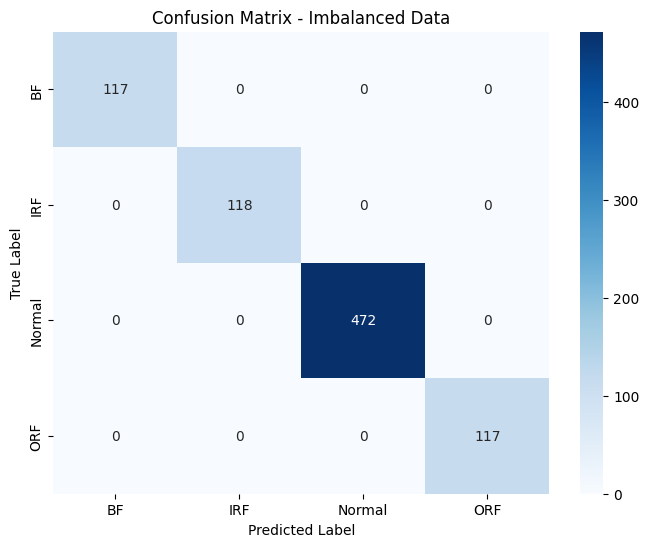


--- Evaluating Model for Experiment: Balanced Data (SMOTE) ---

Classification Report:
              precision    recall  f1-score   support

          BF     1.0000    1.0000    1.0000       117
         IRF     1.0000    1.0000    1.0000       118
      Normal     1.0000    1.0000    1.0000       472
         ORF     1.0000    1.0000    1.0000       117

    accuracy                         1.0000       824
   macro avg     1.0000    1.0000    1.0000       824
weighted avg     1.0000    1.0000    1.0000       824

Overall Test Accuracy: 1.0000


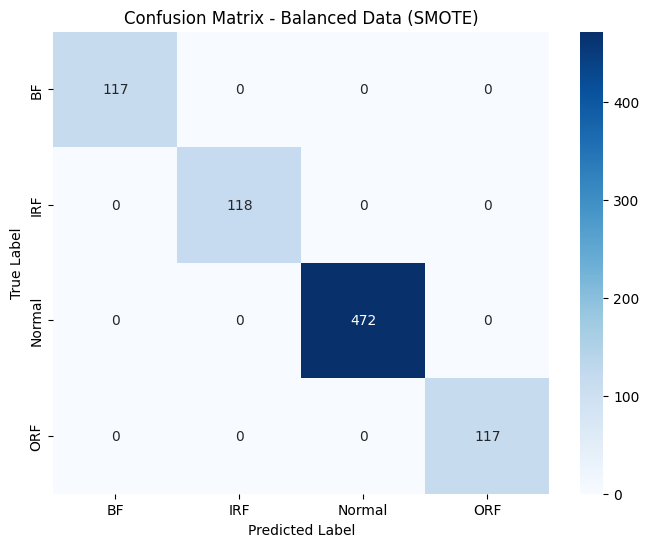

In [11]:
def evaluate_model(model, test_loader, device, label_encoder, experiment_name):
    print(f"\n--- Evaluating Model for Experiment: {experiment_name} ---")
    
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    class_names = label_encoder.classes_
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    print(f"Overall Test Accuracy: {accuracy_score(all_labels, all_preds):.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {experiment_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

evaluate_model(imbalanced_model, test_loader, device, label_encoder, "Imbalanced Data")
evaluate_model(balanced_model, test_loader, device, label_encoder, "Balanced Data (SMOTE)")

### 9. Save Best Model

In [12]:
MODELS_DIR = os.path.join(project_root, 'models')
os.makedirs(MODELS_DIR, exist_ok=True)

# Let's save the model trained on balanced data, as it's likely more robust.
# Note: The user mentioned their model was named 'best_1d_cnn_model.pth'
MODEL_SAVE_PATH = os.path.join(MODELS_DIR, 'best_1d_cnn_model.pth')

torch.save(balanced_model.state_dict(), MODEL_SAVE_PATH)

print(f"Best performing model saved to: {MODEL_SAVE_PATH}")

Best performing model saved to: D:\Coding\GitHub\AI-Bearing-Diagnosis\models\best_1d_cnn_model.pth


### 10. Robustness Testing with Noise Injection


--- Starting Enhanced Robustness Test: Noise Injection ---
Standard Deviation of the original test signal: 0.8669

--- Evaluating Model: Baseline (No Noise) ---
Classification Report:
              precision    recall  f1-score   support

          BF     1.0000    1.0000    1.0000       117
         IRF     1.0000    1.0000    1.0000       118
      Normal     1.0000    1.0000    1.0000       472
         ORF     1.0000    1.0000    1.0000       117

    accuracy                         1.0000       824
   macro avg     1.0000    1.0000    1.0000       824
weighted avg     1.0000    1.0000    1.0000       824

Overall Test Accuracy: 1.0000

Confusion matrix saved: confusion_matrix_baseline.png


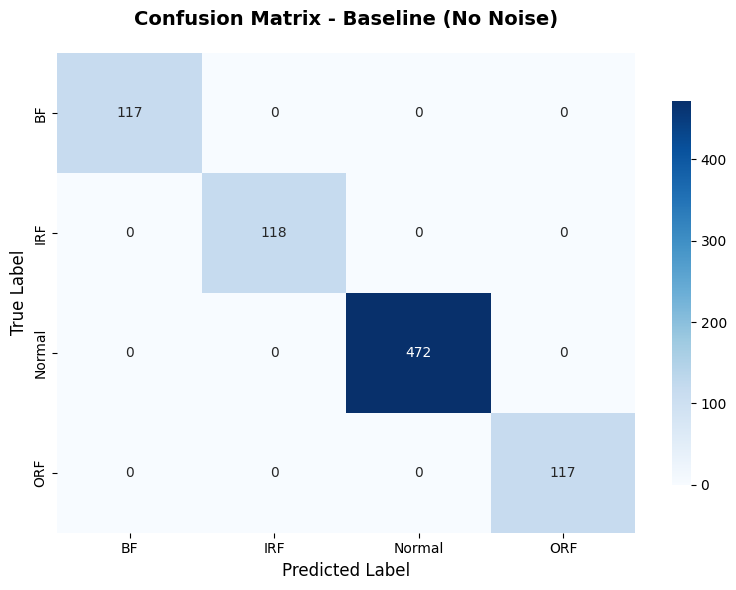


--- Evaluating Model: Noise Level 25% ---
Classification Report:
              precision    recall  f1-score   support

          BF     1.0000    1.0000    1.0000       117
         IRF     1.0000    1.0000    1.0000       118
      Normal     1.0000    1.0000    1.0000       472
         ORF     1.0000    1.0000    1.0000       117

    accuracy                         1.0000       824
   macro avg     1.0000    1.0000    1.0000       824
weighted avg     1.0000    1.0000    1.0000       824

Overall Test Accuracy: 1.0000

Confusion matrix saved: confusion_matrix_noise_25pct.png


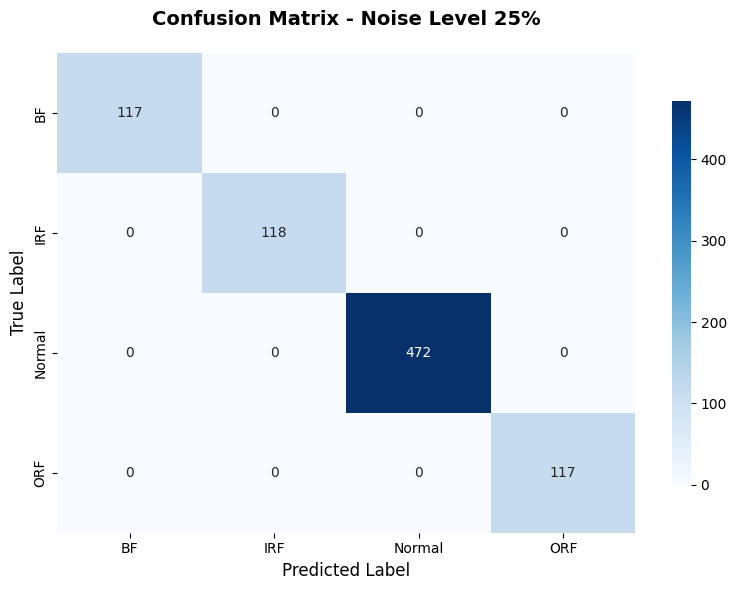


--- Evaluating Model: Noise Level 50% ---
Classification Report:
              precision    recall  f1-score   support

          BF     1.0000    0.0855    0.1575       117
         IRF     0.5244    1.0000    0.6880       118
      Normal     1.0000    1.0000    1.0000       472
         ORF     1.0000    1.0000    1.0000       117

    accuracy                         0.8701       824
   macro avg     0.8811    0.7714    0.7114       824
weighted avg     0.9319    0.8701    0.8357       824

Overall Test Accuracy: 0.8701

Confusion matrix saved: confusion_matrix_noise_50pct.png


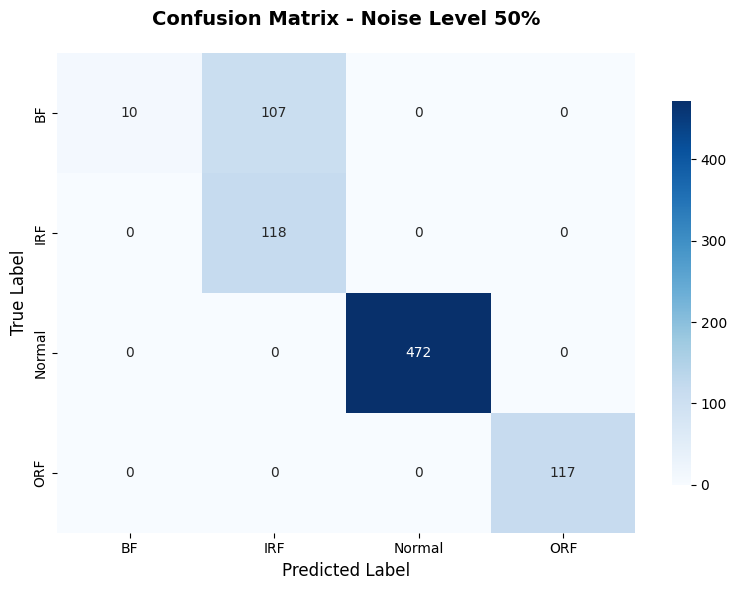


--- Evaluating Model: Noise Level 75% ---
Classification Report:
              precision    recall  f1-score   support

          BF     0.0000    0.0000    0.0000       117
         IRF     0.1674    1.0000    0.2868       118
      Normal     1.0000    0.0042    0.0084       472
         ORF     1.0000    1.0000    1.0000       117

    accuracy                         0.2876       824
   macro avg     0.5418    0.5011    0.3238       824
weighted avg     0.7388    0.2876    0.1879       824

Overall Test Accuracy: 0.2876



D:\Coding\GitHub\AI-Bearing-Diagnosis\ai_bearing_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Coding\GitHub\AI-Bearing-Diagnosis\ai_bearing_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Coding\GitHub\AI-Bearing-Diagnosis\ai_bearing_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Confusion matrix saved: confusion_matrix_noise_75pct.png


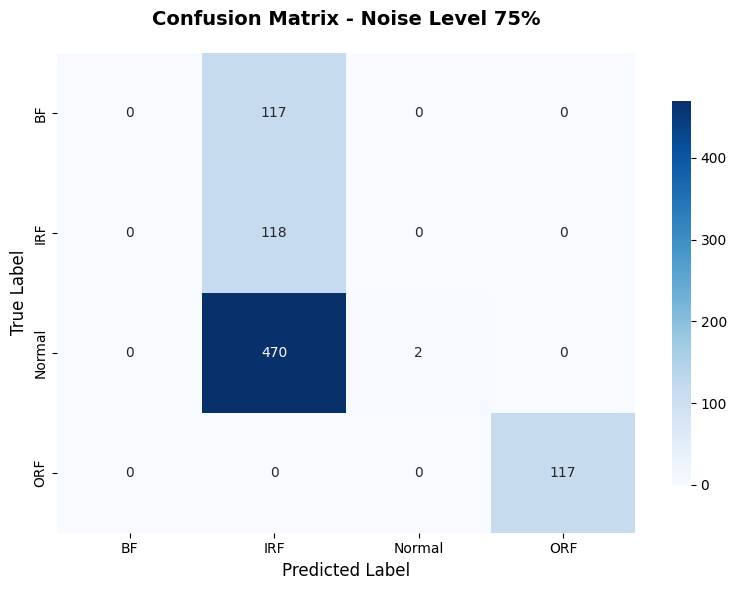


--- Evaluating Model: Noise Level 100% ---
Classification Report:
              precision    recall  f1-score   support

          BF     0.0000    0.0000    0.0000       117
         IRF     0.1580    1.0000    0.2728       118
      Normal     0.0000    0.0000    0.0000       472
         ORF     1.0000    0.6581    0.7938       117

    accuracy                         0.2367       824
   macro avg     0.2895    0.4145    0.2667       824
weighted avg     0.1646    0.2367    0.1518       824

Overall Test Accuracy: 0.2367



D:\Coding\GitHub\AI-Bearing-Diagnosis\ai_bearing_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Coding\GitHub\AI-Bearing-Diagnosis\ai_bearing_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Coding\GitHub\AI-Bearing-Diagnosis\ai_bearing_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Confusion matrix saved: confusion_matrix_noise_100pct.png


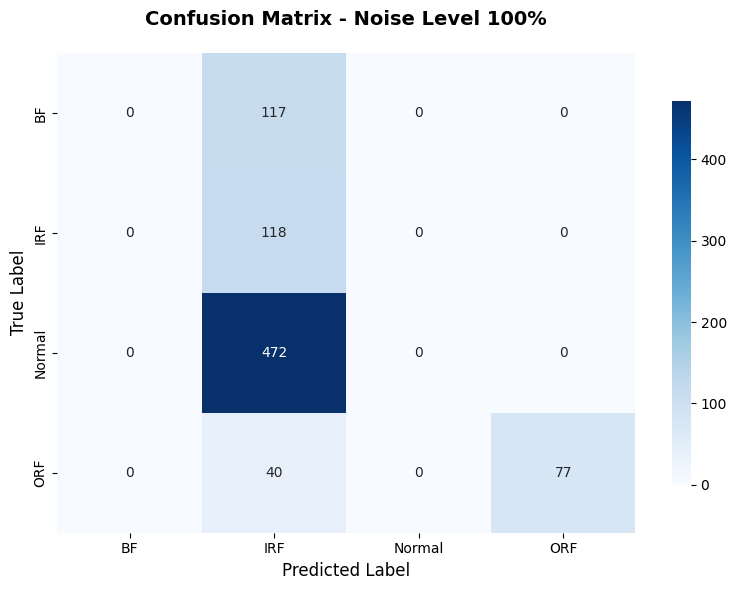


ROBUSTNESS TEST SUMMARY
Noise_Level          Experiment  Accuracy  Precision  Recall  F1-Score  Noise_Std_Dev
         0% Baseline (No Noise)    1.0000     1.0000  1.0000    1.0000       0.000000
        25%     Noise Level 25%    1.0000     1.0000  1.0000    1.0000       0.216718
        50%     Noise Level 50%    0.8701     0.9319  0.8701    0.8357       0.433436
        75%     Noise Level 75%    0.2876     0.7388  0.2876    0.1879       0.650154
       100%    Noise Level 100%    0.2367     0.1646  0.2367    0.1518       0.866872

Results saved to: robustness_test_results.csv


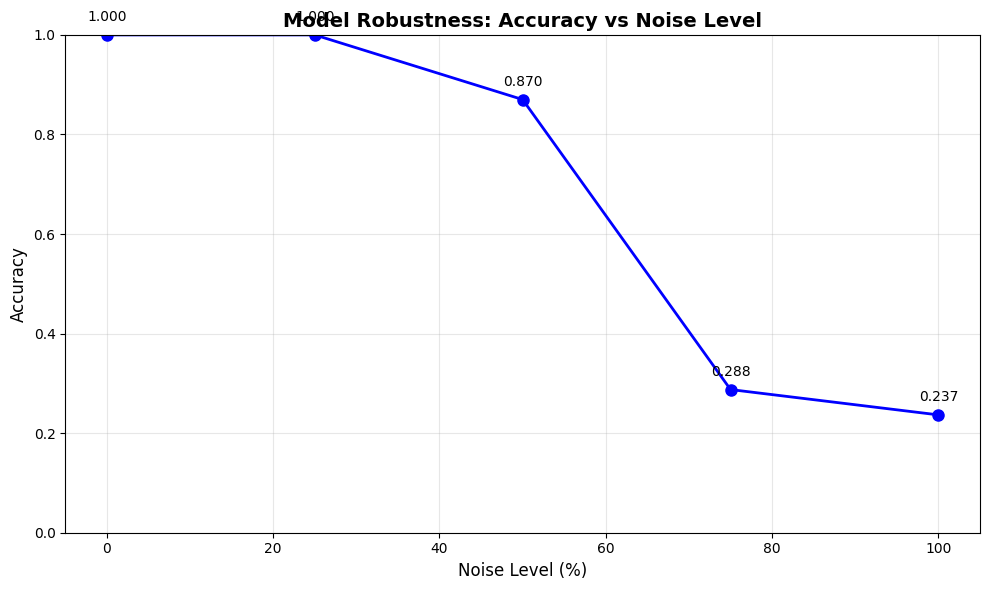


--- Robustness Test Completed ---
Generated files:
  • CSV results: robustness_test_results.csv
  • Accuracy plot: robustness_accuracy_plot.png
  • Confusion matrices: confusion_matrix_*.png


In [14]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# Enhanced evaluation function that returns metrics
def evaluate_model_with_metrics(model, test_loader, device, label_encoder, experiment_name, save_path=None):
    """
    Evaluates model and returns metrics for summary table.
    """
    print(f"--- Evaluating Model: {experiment_name} ---")
    
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    class_names = label_encoder.classes_
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    print(f"Overall Test Accuracy: {accuracy:.4f}\n")

    # Create and save confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    plt.style.use('default')
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'shrink': 0.8})
    
    plt.title(f'Confusion Matrix - {experiment_name}', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Confusion matrix saved: {save_path}")
    
    plt.show()
    
    # Return metrics for summary table
    return {
        'Experiment': experiment_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

# --- Enhanced Robustness Testing ---
print("\n--- Starting Enhanced Robustness Test: Noise Injection ---")

model_to_test = balanced_model
noise_levels = [0.0, 0.25, 0.50, 0.75, 1.0]  # Added 0.0 for baseline

# Calculate signal standard deviation
signal_std_dev = X_test_scaled.std()
print(f"Standard Deviation of the original test signal: {signal_std_dev:.4f}")

# Store results for summary table
results_summary = []

for level in noise_levels:
    if level == 0.0:
        # Baseline test without noise
        experiment_name = "Baseline (No Noise)"
        test_loader_to_use = test_loader
        save_path = "confusion_matrix_baseline.png"
    else:
        # Create noisy data
        noise_std_dev = signal_std_dev * level
        noise = torch.randn_like(X_test_tensor) * noise_std_dev
        X_test_noisy = X_test_tensor + noise
        
        experiment_name = f"Noise Level {int(level*100)}%"
        save_path = f"confusion_matrix_noise_{int(level*100)}pct.png"
        
        # Create noisy dataset and loader
        noisy_dataset = BearingDataset(X_test_noisy, y_test_tensor)
        test_loader_to_use = DataLoader(dataset=noisy_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"\n{'='*60}")
    
    # Evaluate and collect metrics
    metrics = evaluate_model_with_metrics(
        model=model_to_test,
        test_loader=test_loader_to_use,
        device=device,
        label_encoder=label_encoder,
        experiment_name=experiment_name,
        save_path=save_path
    )
    
    # Add noise level info
    metrics['Noise_Level'] = f"{int(level*100)}%"
    metrics['Noise_Std_Dev'] = signal_std_dev * level if level > 0 else 0.0
    
    results_summary.append(metrics)

# Create and display summary table
print(f"\n{'='*80}")
print("ROBUSTNESS TEST SUMMARY")
print(f"{'='*80}")

df_results = pd.DataFrame(results_summary)
df_results = df_results[['Noise_Level', 'Experiment', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Noise_Std_Dev']]

# Format the numeric columns for better display
for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    df_results[col] = df_results[col].round(4)
df_results['Noise_Std_Dev'] = df_results['Noise_Std_Dev'].round(6)

print(df_results.to_string(index=False))

# Save results to CSV
csv_filename = "robustness_test_results.csv"
df_results.to_csv(csv_filename, index=False)
print(f"\nResults saved to: {csv_filename}")

# Create a summary plot of accuracy vs noise level
plt.figure(figsize=(10, 6))
plt.plot([0, 25, 50, 75, 100], df_results['Accuracy'], 'bo-', linewidth=2, markersize=8)
plt.title('Model Robustness: Accuracy vs Noise Level', fontsize=14, fontweight='bold')
plt.xlabel('Noise Level (%)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

# Add value labels on points
for i, (noise, acc) in enumerate(zip([0, 25, 50, 75, 100], df_results['Accuracy'])):
    plt.annotate(f'{acc:.3f}', (noise, acc), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('robustness_accuracy_plot.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n--- Robustness Test Completed ---")
print(f"Generated files:")
print(f"  • CSV results: {csv_filename}")
print(f"  • Accuracy plot: robustness_accuracy_plot.png")
print(f"  • Confusion matrices: confusion_matrix_*.png")